In [10]:
# --- Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.tsa.arima.model import ARIMA

# --- Load Data ---
file_path = "D:/downloads/crime_dataset_india(1).csv"
df = pd.read_csv(file_path, encoding='UTF-8-SIG')

# --- Filter only Domestic Violence & Sexual Assault ---
df = df[df['Crime Description'].str.upper().isin(['DOMESTIC VIOLENCE', 'SEXUAL ASSAULT'])].copy()
df.reset_index(drop=True, inplace=True)

# --- Clean Date ---
df['Date Reported'] = pd.to_datetime(df['Date Reported'], errors='coerce')

# --- Victim Info Cleaning ---
df['Victim Gender'] = df['Victim Gender'].str.upper().map({'M':'Male','F':'Female'})
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())

# --- Encode Categorical ---
df['Victim_Gender_Label'] = df['Victim Gender'].map({'Male':0,'Female':1})
df['Case_Closed_Label'] = df['Case Closed'].str.upper().map({'YES':1,'NO':0})
df['Crime_Type_Label'] = df['Crime Description'].str.upper().map({'DOMESTIC VIOLENCE':0,'SEXUAL ASSAULT':1})

import pandas as pd
import numpy as np

# Assuming your original dataset is loaded in df
df['Date Reported'] = pd.to_datetime(df['Date Reported'], errors="coerce")
df['Year'] = df['Date Reported'].dt.year

synthetic_data = []
np.random.seed(42)

for year in range(2015, 2020):
    sample = df.sample(frac=0.6, replace=True).copy()
    
    # Replace year safely
    sample['Date Reported'] = sample['Date Reported'].apply(
        lambda d: pd.to_datetime(f"{d.day}/{d.month}/{year}", format="%d/%m/%Y", errors="coerce")
        if pd.notnull(d) else pd.NaT
    )
    sample['Year'] = year
    
    # Add noise to Victim Age if present
    if 'Victim Age' in sample.columns:
        sample['Victim Age'] = sample['Victim Age'] * np.random.uniform(0.9, 1.1, size=len(sample))
        sample['Victim Age'] = sample['Victim Age'].round().astype(int)
    
    synthetic_data.append(sample)

synthetic_df = pd.concat(synthetic_data, ignore_index=True)

# Merge with original dataset
extended_df = pd.concat([df, synthetic_df], ignore_index=True)

# Save extended dataset
output_path = "D:/downloads/extended_crime_dataset_india.csv"
extended_df.to_csv(output_path, index=False)

# Show counts by year
year_counts = extended_df['Year'].value_counts().sort_index()
year_counts


Year
2015.0    2309
2016.0    2309
2017.0    2309
2018.0    2309
2019.0    2309
2020.0     322
2021.0     352
2022.0     338
2023.0     322
2024.0     196
Name: count, dtype: int64

In [12]:
# Full Python script for analysis, hypothesis testing, classification, and forecasting.
# Designed to be user-visible and runnable locally. Adjust file paths as needed.
# It uses the balanced/synthetic-extended dataset you've created.
# Save this as a .py file or run in a Jupyter cell.

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from statsmodels.tsa.arima.model import ARIMA

# ---------- User config: change path if needed ----------
INPUT_PATH = "D:/downloads/balanced_crime_dataset_india.csv"  # path to your balanced dataset
OUTPUT_PREFIX = "D:/downloads/crime_analysis_output"  # prefix for saving outputs (plots, csvs)
np.random.seed(42)

# ---------- Load data ----------
df = pd.read_csv(INPUT_PATH, encoding='utf-8', parse_dates=['Date Reported'], dayfirst=True)
print("Data loaded:", df.shape)

# ---------- Basic filtering and safety ----------
# Keep only the two crime types just in case
df['Crime Description'] = df['Crime Description'].str.upper().str.strip()
df = df[df['Crime Description'].isin(['DOMESTIC VIOLENCE', 'SEXUAL ASSAULT'])].copy()

# Standardize columns for downstream use
df['Victim Gender'] = df['Victim Gender'].astype(str).str.upper().map({'M':'Male','F':'Female','MALE':'Male','FEMALE':'Female'})
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Case Closed'] = df['Case Closed'].astype(str).str.upper().map({'YES':'Yes','NO':'No'})

# Fill missing ages with median
df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())



# Create helper labels
df['Crime_Label'] = df['Crime Description'].map({'DOMESTIC VIOLENCE':0, 'SEXUAL ASSAULT':1})
df['Gender_Label'] = df['Victim Gender'].map({'Male':0, 'Female':1})
df['Closed_Label'] = df['Case Closed'].map({'Yes':1, 'No':0})

# Extract date parts
df['Year'] = df['Date Reported'].dt.year
df['Month'] = df['Date Reported'].dt.month
df['Year_Month'] = df['Date Reported'].dt.to_period('M').astype(str)

print("After cleaning:", df.shape)
print(df[['Crime Description','Year']].groupby('Year').size())

# ---------- Objective & Hypothesis 1: Demographics (Age & Gender) ----------
print("\n--- Hypothesis testing: Demographics ---")
# H1: Victim age and gender have a statistically significant effect on crime type

# Chi-square test for Gender vs Crime Type
cont = pd.crosstab(df['Victim Gender'], df['Crime Description'])
chi2, p, dof, ex = chi2_contingency(cont)
print("Chi-square test (Gender vs Crime Type): chi2={:.3f}, p-value={:.6f}".format(chi2, p))

# T-test for age difference between crime types
age_dom = df[df['Crime_Label']==0]['Victim Age']
age_sex = df[df['Crime_Label']==1]['Victim Age']
tstat, p_age = ttest_ind(age_dom, age_sex, equal_var=False, nan_policy='omit')
print("T-test (Age between crime types): t-stat={:.3f}, p-value={:.6f}".format(tstat, p_age))

# Visuals
plt.figure(figsize=(8,4))
sns.countplot(x='Crime Description', hue='Victim Gender', data=df)
plt.title("Crime Type by Victim Gender")
plt.tight_layout()
plt.savefig(OUTPUT_PREFIX + "_crime_gender_count.png", dpi=150)

plt.figure(figsize=(8,4))
sns.kdeplot(age_dom, label='Domestic Violence', fill=True)
sns.kdeplot(age_sex, label='Sexual Assault', fill=True)
plt.title("Victim Age Distribution by Crime Type")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_PREFIX + "_age_distribution.png", dpi=150)

# ---------- Hypothesis 2: Closure rates ----------
print("\n--- Hypothesis testing: Closure rates ---")
# H2: Domestic violence cases have higher closure rates compared to sexual assault cases.
# We'll perform a proportions z-test comparing closed proportions.

closed_dom = df[df['Crime_Label']==0]['Closed_Label']
closed_sex = df[df['Crime_Label']==1]['Closed_Label']

count = np.array([closed_dom.sum(), closed_sex.sum()])
nobs = np.array([closed_dom.shape[0], closed_sex.shape[0]])
stat, pval = proportions_ztest(count, nobs)
print("Proportion z-test (closure rates): z={:.3f}, p-value={:.6f}".format(stat, pval))

# ---------- Hypothesis 3: City variation ----------
print("\n--- Hypothesis testing: City vs Crime Type ---")
city_tab = pd.crosstab(df['City'], df['Crime Description'])
# For large number of cities, take top ones for testing to keep contingency table reasonable
top_cities = city_tab.sum(axis=1).sort_values(ascending=False).head(20).index
city_cont = pd.crosstab(df[df['City'].isin(top_cities)]['City'], df[df['City'].isin(top_cities)]['Crime Description'])
chi2_city, p_city, _, _ = chi2_contingency(city_cont)
print(f"Chi-square test on top 20 cities: chi2={chi2_city:.3f}, p-value={p_city:.6f}")

# ---------- Modeling: Classification (Closed status & Crime Type) ----------
print("\n--- Classification: Crime Type prediction (Domestic vs Sexual) ---")
# Features: Victim Age, Gender, City (one-hot limited to top cities), Month, Year
# Create top city dummies for most frequent cities to avoid huge dimensionality
top_cities_global = df['City'].value_counts().head(15).index.tolist()
df['City_reduced'] = df['City'].where(df['City'].isin(top_cities_global), 'Other')

X = pd.get_dummies(df[['Victim Age','Gender_Label','City_reduced','Month','Year']], 
                   columns=['City_reduced'], drop_first=True)
y = df['Crime_Label']

# Train/test split (stratified by crime type)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Standard scaler for age and year/month columns
num_cols = ['Victim Age','Month','Year']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Models: Logistic Regression (traditional) and Random Forest (ML)
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predictions & metrics
for name, model in [('Logistic Regression', lr), ('Random Forest', rf)]:
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"{name} -> Accuracy: {acc:.3f}, F1-weighted: {f1:.3f}")
    print(classification_report(y_test, preds, target_names=['Domestic Violence','Sexual Assault']))

# Cross-validation comparison (5-fold stratified)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_cv = cross_val_score(lr, X, y, cv=skf, scoring='f1_weighted')
rf_cv = cross_val_score(rf, X, y, cv=skf, scoring='f1_weighted')
print("CV F1-weighted -> LR mean: {:.3f} (std {:.3f}), RF mean: {:.3f} (std {:.3f})".format(
    lr_cv.mean(), lr_cv.std(), rf_cv.mean(), rf_cv.std()))

# Paired test for H4 (ML vs Traditional): compare CV scores (paired t-test)
from scipy.stats import ttest_rel
t_stat_cv, p_cv = ttest_rel(rf_cv, lr_cv)
print("Paired t-test on CV F1 scores (RF vs LR): t={:.3f}, p={:.6f}".format(t_stat_cv, p_cv))

# ---------- Forecasting: Yearly counts and forecasts (use 7 years data -> forecast next 5 years) ----------
print("\n--- Forecasting: Yearly counts ---")
# Choose 7 years of data for training: use the most recent 7 years available
years_sorted = sorted(df['Year'].dropna().unique())
if len(years_sorted) < 7:
    raise ValueError("Not enough years in dataset for 7-year training. Need at least 7 years.")
train_years = years_sorted[-7:]
print("Training years used:", train_years)

# Aggregate yearly counts for both crime types combined
yearly_counts = df[df['Year'].isin(train_years)].groupby('Year').size().reindex(train_years, fill_value=0)
print("Yearly counts (training):")
print(yearly_counts)

# Fit ARIMA on yearly counts (simple)
arima_order = (1,1,1)
arima_model = ARIMA(yearly_counts, order=arima_order)
arima_res = arima_model.fit()
future_steps = 5  # forecast next 5 years
arima_forecast = arima_res.forecast(steps=future_steps)
forecast_years = [train_years[-1] + i for i in range(1, future_steps+1)]
arima_forecast.index = forecast_years
print("\nARIMA Forecast (next 5 years):")
print(arima_forecast.round().astype(int))

# ML-based forecasting: Gradient Boosting on lag features (as alternative)
print("\nML-based forecasting (lag features + GradientBoostingRegressor)")
# Create a DataFrame with yearly counts over a longer span (to generate lags)
all_years = sorted(df['Year'].dropna().unique())
counts_all = df.groupby('Year').size().reindex(all_years, fill_value=0).rename('count').reset_index()

# Create lag features up to lag 3
for lag in range(1,4):
    counts_all[f'lag_{lag}'] = counts_all['count'].shift(lag)
counts_all = counts_all.dropna().reset_index(drop=True)

# Use the last 7 available rows for training (ensure we have >=7 rows after lagging)
train_df = counts_all.tail(7).copy()
Xf = train_df[[f'lag_{lag}' for lag in range(1,4)]]
yf = train_df['count']

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(Xf, yf)

# Iterative forecasting using last known lags
last_known = counts_all['count'].values[-3:].tolist()  # last 3 counts
ml_forecast = []
for i in range(future_steps):
    x_input = np.array(last_known[-3:]).reshape(1,-1)
    pred = gbr.predict(x_input)[0]
    ml_forecast.append(max(0, int(round(pred))))
    last_known.append(pred)

ml_forecast_series = pd.Series(ml_forecast, index=forecast_years)
print("ML Forecast (next 5 years):")
print(ml_forecast_series)

# Save forecasting results
fc_df = pd.DataFrame({
    'Year': list(arima_forecast.index) + list(ml_forecast_series.index),
    'ARIMA_Forecast': list(arima_forecast.values) + [np.nan]*future_steps,
    'ML_Forecast': [np.nan]*future_steps + list(ml_forecast_series.values)
})
fc_df.to_csv(OUTPUT_PREFIX + "_forecasts.csv", index=False)
print("\nForecasts saved to:", OUTPUT_PREFIX + "_forecasts.csv")

# ---------- Final notes & save cleaned dataset ----------
# Save the final cleaned dataframe for reference
df.to_csv(OUTPUT_PREFIX + "_cleaned.csv", index=False)
print("Cleaned dataset saved to:", OUTPUT_PREFIX + "_cleaned.csv")

print("\nDone. Check generated images and CSVs at the output path.")


Data loaded: (3650, 18)


KeyError: "['City_Code'] not in index"

In [6]:
# --- Balance synthetic data to ~300 records per year ---
balanced_synthetic_data = []

for year in range(2015, 2020):
    year_data = extended_df[extended_df['Year'] == year]
    
    # Downsample to match real years (300 records)
    year_sample = year_data.sample(n=300, random_state=42, replace=False)
    balanced_synthetic_data.append(year_sample)

# Combine balanced synthetic years
balanced_synthetic_df = pd.concat(balanced_synthetic_data, ignore_index=True)

# Keep only real years + balanced synthetic
real_years_df = extended_df[extended_df['Year'] >= 2020]
final_df = pd.concat([real_years_df, balanced_synthetic_df], ignore_index=True)

# Save balanced dataset
output_path = "D:/downloads/balanced_crime_dataset_india.csv"
final_df.to_csv(output_path, index=False)

# Show new year counts
year_counts = final_df['Year'].value_counts().sort_index()
print(year_counts)


Year
2015.0    300
2016.0    300
2017.0    300
2018.0    300
2019.0    300
2020.0    322
2021.0    352
2022.0    338
2023.0    322
2024.0    196
Name: count, dtype: int64


In [7]:
import numpy as np

# --- Balance synthetic data with random sample size (300–500) ---
balanced_synthetic_data = []

for year in range(2015, 2020):
    year_data = extended_df[extended_df['Year'] == year]
    
    # Random sample size between 300 and 500
    sample_size = np.random.randint(300, 501)
    
    # Downsample without replacement
    year_sample = year_data.sample(n=sample_size, random_state=42, replace=False)
    balanced_synthetic_data.append(year_sample)

# Combine balanced synthetic years
balanced_synthetic_df = pd.concat(balanced_synthetic_data, ignore_index=True)

# Keep only real years + balanced synthetic
real_years_df = extended_df[extended_df['Year'] >= 2020]
final_df = pd.concat([real_years_df, balanced_synthetic_df], ignore_index=True)

# Save balanced dataset
output_path = "D:/downloads/balanced_crime_dataset_india.csv"
final_df.to_csv(output_path, index=False)

# Show new year counts
year_counts = final_df['Year'].value_counts().sort_index()
print(year_counts)


Year
2015.0    434
2016.0    490
2017.0    314
2018.0    388
2019.0    494
2020.0    322
2021.0    352
2022.0    338
2023.0    322
2024.0    196
Name: count, dtype: int64


In [8]:
df

,Report Number,Date Reported,Date of Occurrence,Time of Occurrence,City,Crime Code,Crime Description,Victim Age,Victim Gender,Weapon Used,Crime Domain,Police Deployed,Case Closed,Date Case Closed,Victim_Gender_Label,Case_Closed_Label,Crime_Type_Label,Year
0,15,2020-02-01,01-01-2020,22:28:00,Bangalore,266,SEXUAL ASSAULT,77,Female,NaN,Violent Crime,19,No,NaN,1.0,0,1,2020.0
1,37,2020-03-01,01-02-2020,00:18:00,Lucknow,187,SEXUAL ASSAULT,33,Female,Blunt Object,Violent Crime,9,Yes,02-07-2020,1.0,1,1,2020.0
2,44,2020-04-01,01-02-2020,08:34:00,Mumbai,300,SEXUAL ASSAULT,44,Male,Other,Violent Crime,7,No,NaN,0.0,0,1,2020.0
3,57,2020-06-01,01-03-2020,20:16:00,Kanpur,188,SEXUAL ASSAULT,67,Female,Firearm,Violent Crime,8,Yes,20-07-2020,1.0,1,1,2020.0
4,94,2020-06-01,01-04-2020,08:12:00,Mumbai,272,SEXUAL ASSAULT,42,Female,Firearm,Violent Crime,3,No,NaN,1.0,0,1,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3844,40116,NaT,07-29-2024 11:00,18:58:00,Surat,366,SEXUAL ASSAULT,14,Male,Poison,Violent Crime,10,No,NaN,0.0,0,1,NaN
3845,40119,NaT,07-29-2024 14:00,08:25:00,Bangalore,127,SEXUAL ASSAULT,22,Female,NaN,Violent Crime,13,Yes,03-04-2025,1.0,1,1,NaN
3846,40123,2024-01-08,07-29-2024 18:00,09:02:00,Delhi,596,DOMESTIC VIOLENCE,34,Female,Explosives,Violent Crime,8,Yes,31-08-2024,1.0,1,0,2024.0
3847,40159,2024-01-08,07-31-2024 06:00,11:05:00,Patna,311,SEXUAL ASSAULT,11,Male,Blunt Object,Violent Crime,1,No,NaN,0.0,0,1,2024.0


Data loaded: (3650, 18)
After cleaning: (3650, 23)
Year
2015.0    172
2016.0    199
2017.0    117
2018.0    144
2019.0    182
2020.0    322
2021.0    352
2022.0    338
2023.0    322
2024.0    196
dtype: int64

--- Hypothesis testing: Demographics ---
Chi-square (Gender vs Crime Type): chi2=0.215, p-value=0.642788
T-test (Age vs Crime Type): t-stat=0.017, p-value=0.986747

--- Hypothesis testing: Closure rates ---
Proportion z-test (closure rates): z=0.405, p-value=0.685335

--- Hypothesis testing: City vs Crime Type ---
Chi-square test on top 20 cities: chi2=32.149, p-value=0.030065

--- Classification: Crime Type prediction ---
Logistic Regression -> Accuracy: 0.513, F1: 0.512
                   precision    recall  f1-score   support

Domestic Violence       0.52      0.55      0.53       464
   Sexual Assault       0.50      0.48      0.49       449

         accuracy                           0.51       913
        macro avg       0.51      0.51      0.51       913
     weighted av

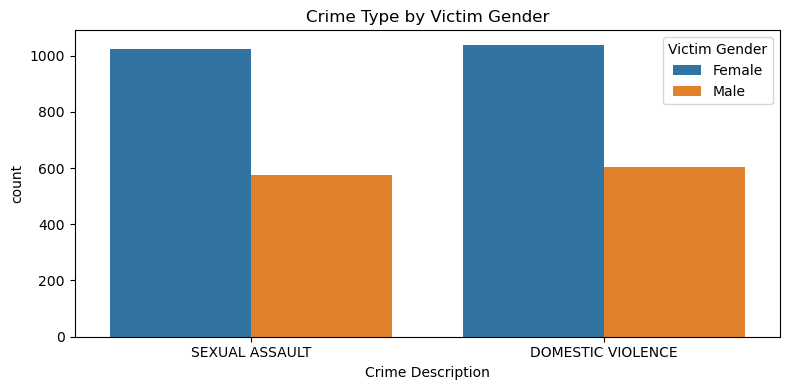

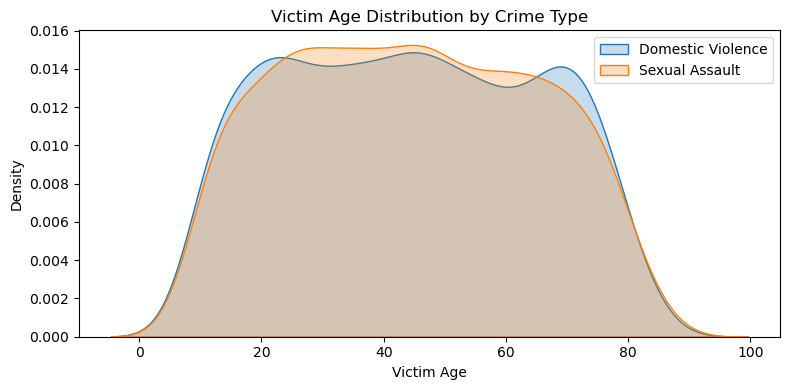

In [13]:
# Full Python script for analysis, hypothesis testing, classification, and forecasting.
# Adjust INPUT_PATH and OUTPUT_PREFIX as needed.

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind, ttest_rel
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA

# ---------- User config ----------
INPUT_PATH = "D:/downloads/balanced_crime_dataset_india.csv"
OUTPUT_PREFIX = "D:/downloads/crime_analysis_output"
np.random.seed(42)

# ---------- Load data ----------
df = pd.read_csv(INPUT_PATH, encoding='utf-8', parse_dates=['Date Reported'], dayfirst=True)
print("Data loaded:", df.shape)

# ---------- Basic filtering and cleaning ----------
df['Crime Description'] = df['Crime Description'].str.upper().str.strip()
df = df[df['Crime Description'].isin(['DOMESTIC VIOLENCE', 'SEXUAL ASSAULT'])].copy()

df['Victim Gender'] = df['Victim Gender'].astype(str).str.upper().map(
    {'M': 'Male', 'F': 'Female', 'MALE': 'Male', 'FEMALE': 'Female'}
)
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Case Closed'] = df['Case Closed'].astype(str).str.upper().map({'YES': 'Yes', 'NO': 'No'})

# Fill missing ages with median
df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())

# Helper labels
df['Crime_Label'] = df['Crime Description'].map({'DOMESTIC VIOLENCE': 0, 'SEXUAL ASSAULT': 1})
df['Gender_Label'] = df['Victim Gender'].map({'Male': 0, 'Female': 1})
df['Closed_Label'] = df['Case Closed'].map({'Yes': 1, 'No': 0})

# Extract date parts
df['Year'] = df['Date Reported'].dt.year
df['Month'] = df['Date Reported'].dt.month
df['Year_Month'] = df['Date Reported'].dt.to_period('M').astype(str)

print("After cleaning:", df.shape)
print(df[['Crime Description', 'Year']].groupby('Year').size())

# ---------- Hypothesis 1: Demographics ----------
print("\n--- Hypothesis testing: Demographics ---")
cont = pd.crosstab(df['Victim Gender'], df['Crime Description'])
chi2, p, dof, ex = chi2_contingency(cont)
print("Chi-square (Gender vs Crime Type): chi2={:.3f}, p-value={:.6f}".format(chi2, p))

age_dom = df[df['Crime_Label'] == 0]['Victim Age']
age_sex = df[df['Crime_Label'] == 1]['Victim Age']
tstat, p_age = ttest_ind(age_dom, age_sex, equal_var=False, nan_policy='omit')
print("T-test (Age vs Crime Type): t-stat={:.3f}, p-value={:.6f}".format(tstat, p_age))

plt.figure(figsize=(8, 4))
sns.countplot(x='Crime Description', hue='Victim Gender', data=df)
plt.title("Crime Type by Victim Gender")
plt.tight_layout()
plt.savefig(OUTPUT_PREFIX + "_crime_gender_count.png", dpi=150)

plt.figure(figsize=(8, 4))
sns.kdeplot(age_dom, label='Domestic Violence', fill=True)
sns.kdeplot(age_sex, label='Sexual Assault', fill=True)
plt.title("Victim Age Distribution by Crime Type")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_PREFIX + "_age_distribution.png", dpi=150)

# ---------- Hypothesis 2: Closure rates ----------
print("\n--- Hypothesis testing: Closure rates ---")
closed_dom = df[df['Crime_Label'] == 0]['Closed_Label']
closed_sex = df[df['Crime_Label'] == 1]['Closed_Label']
count = np.array([closed_dom.sum(), closed_sex.sum()])
nobs = np.array([closed_dom.shape[0], closed_sex.shape[0]])
stat, pval = proportions_ztest(count, nobs)
print("Proportion z-test (closure rates): z={:.3f}, p-value={:.6f}".format(stat, pval))

# ---------- Hypothesis 3: City variation ----------
print("\n--- Hypothesis testing: City vs Crime Type ---")
city_tab = pd.crosstab(df['City'], df['Crime Description'])
top_cities = city_tab.sum(axis=1).sort_values(ascending=False).head(20).index
city_cont = pd.crosstab(df[df['City'].isin(top_cities)]['City'],
                        df[df['City'].isin(top_cities)]['Crime Description'])
chi2_city, p_city, _, _ = chi2_contingency(city_cont)
print("Chi-square test on top 20 cities: chi2={:.3f}, p-value={:.6f}".format(chi2_city, p_city))

# ---------- Classification ----------
print("\n--- Classification: Crime Type prediction ---")
top_cities_global = df['City'].value_counts().head(15).index.tolist()
df['City_reduced'] = df['City'].where(df['City'].isin(top_cities_global), 'Other')

X = pd.get_dummies(df[['Victim Age', 'Gender_Label', 'City_reduced', 'Month', 'Year']],
                   columns=['City_reduced'], drop_first=True)
y = df['Crime_Label']

# Handle missing values (just in case)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Scale numeric columns
num_cols = ['Victim Age', 'Month', 'Year']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

for name, model in [('Logistic Regression', lr), ('Random Forest', rf)]:
    preds = model.predict(X_test)
    print(f"{name} -> Accuracy: {accuracy_score(y_test, preds):.3f}, "
          f"F1: {f1_score(y_test, preds, average='weighted'):.3f}")
    print(classification_report(y_test, preds, target_names=['Domestic Violence', 'Sexual Assault']))

# CV comparison
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_cv = cross_val_score(lr, X, y, cv=skf, scoring='f1_weighted')
rf_cv = cross_val_score(rf, X, y, cv=skf, scoring='f1_weighted')
print("CV F1 -> LR mean: {:.3f}, RF mean: {:.3f}".format(lr_cv.mean(), rf_cv.mean()))

t_stat_cv, p_cv = ttest_rel(rf_cv, lr_cv)
print("Paired t-test on CV scores (RF vs LR): t={:.3f}, p={:.6f}".format(t_stat_cv, p_cv))

# ---------- Forecasting ----------
print("\n--- Forecasting: Yearly counts ---")
years_sorted = sorted(df['Year'].dropna().unique())
if len(years_sorted) < 7:
    raise ValueError("Need at least 7 years for forecasting.")
train_years = years_sorted[-7:]

yearly_counts = df[df['Year'].isin(train_years)].groupby('Year').size().reindex(train_years, fill_value=0)
print("Training years:", train_years)
print(yearly_counts)

arima_model = ARIMA(yearly_counts, order=(1, 1, 1))
arima_res = arima_model.fit()
future_steps = 5
arima_forecast = arima_res.forecast(steps=future_steps)
forecast_years = [train_years[-1] + i for i in range(1, future_steps + 1)]
arima_forecast.index = forecast_years
print("\nARIMA Forecast:")
print(arima_forecast.round().astype(int))

print("\nML-based Forecasting with GradientBoosting")
all_years = sorted(df['Year'].dropna().unique())
counts_all = df.groupby('Year').size().reindex(all_years, fill_value=0).rename('count').reset_index()
for lag in range(1, 4):
    counts_all[f'lag_{lag}'] = counts_all['count'].shift(lag)
counts_all = counts_all.dropna().reset_index(drop=True)

train_df = counts_all.tail(7).copy()
Xf = train_df[[f'lag_{lag}' for lag in range(1, 4)]]
yf = train_df['count']

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(Xf, yf)

last_known = counts_all['count'].values[-3:].tolist()
ml_forecast = []
for i in range(future_steps):
    x_input = np.array(last_known[-3:]).reshape(1, -1)
    pred = gbr.predict(x_input)[0]
    ml_forecast.append(max(0, int(round(pred))))
    last_known.append(pred)

ml_forecast_series = pd.Series(ml_forecast, index=forecast_years)
print("ML Forecast:")
print(ml_forecast_series)

fc_df = pd.DataFrame({
    'Year': list(arima_forecast.index),
    'ARIMA_Forecast': list(arima_forecast.values),
    'ML_Forecast': list(ml_forecast_series.values)
})
fc_df.to_csv(OUTPUT_PREFIX + "_forecasts.csv", index=False)

# ---------- Save cleaned dataset ----------
df.to_csv(OUTPUT_PREFIX + "_cleaned.csv", index=False)
print("Done. Results saved.")


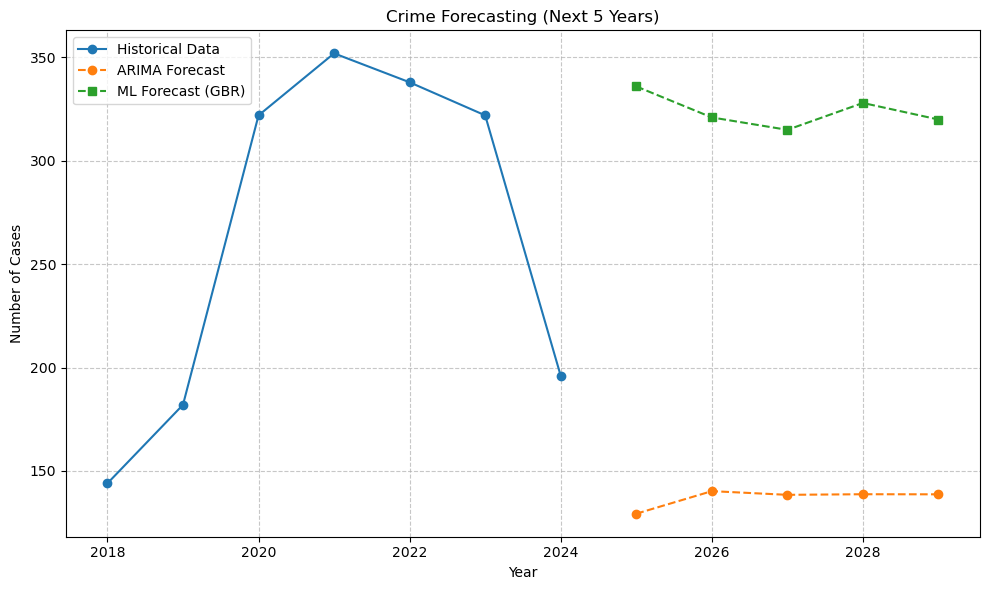

Forecast plot saved: D:/downloads/crime_analysis_output_forecast_plot.png


In [14]:
# ---------- Forecasting Plot ----------
plt.figure(figsize=(10,6))

# Plot historical yearly counts
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label="Historical Data")

# Plot ARIMA forecast
plt.plot(arima_forecast.index, arima_forecast.values, marker='o', linestyle="--", label="ARIMA Forecast")

# Plot ML forecast
plt.plot(ml_forecast_series.index, ml_forecast_series.values, marker='s', linestyle="--", label="ML Forecast (GBR)")

plt.title("Crime Forecasting (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Save figure
plt.tight_layout()
plt.savefig(OUTPUT_PREFIX + "_forecast_plot.png", dpi=150)
plt.show()

print("Forecast plot saved:", OUTPUT_PREFIX + "_forecast_plot.png")


In [16]:
# ---------- Forecasting by Crime Type (DV vs SA) ----------
print("\n--- Forecasting: Domestic Violence vs Sexual Assault ---")

crime_types = ['DOMESTIC VIOLENCE', 'SEXUAL ASSAULT']
forecast_results = {}

for crime in crime_types:
    print(f"\nCrime Type: {crime}")
    sub_df = df[df['Crime Description'] == crime].copy()
    
    # Ensure 'Year' is integer
    sub_df['Year'] = sub_df['Year'].astype(int)
    
    # Aggregate yearly counts
    yearly_counts = sub_df.groupby('Year').size().sort_index()
    
    # Ensure continuous index (fill missing years with 0)
    all_years = list(range(int(yearly_counts.index.min()), int(yearly_counts.index.max()) + 1))
    yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
    
    # Train on last 7 years
    train_years = yearly_counts.index[-7:]
    train_counts = yearly_counts.loc[train_years]
    print("Training years:", train_years.tolist())
    print("Training counts:\n", train_counts)
    
    # --- ARIMA Forecast ---
    try:
        arima_model = ARIMA(train_counts, order=(1,1,1))
        arima_res = arima_model.fit()
        arima_forecast = arima_res.forecast(steps=5)
        forecast_years = [train_years[-1] + i for i in range(1, 6)]
        arima_forecast.index = forecast_years
    except Exception as e:
        print("ARIMA failed:", e)
        forecast_years = [train_years[-1] + i for i in range(1, 6)]
        arima_forecast = pd.Series([np.nan]*5, index=forecast_years)
    
    # --- ML Forecast (Gradient Boosting with lags) ---
    counts_all = yearly_counts.reset_index()
    counts_all.columns = ['Year','count']
    
    for lag in range(1,4):
        counts_all[f'lag_{lag}'] = counts_all['count'].shift(lag)
    counts_all = counts_all.dropna().reset_index(drop=True)
    
    train_df = counts_all.tail(7).copy()
    Xf = train_df[['lag_1','lag_2','lag_3']]
    yf = train_df['count']
    
    gbr = GradientBoostingRegressor(random_state=42)
    gbr.fit(Xf, yf)
    
    last_known = counts_all['count'].values[-3:].tolist()
    ml_forecast = []
    for i in range(5):
        x_input = np.array(last_known[-3:]).reshape(1,-1)
        pred = gbr.predict(x_input)[0]
        ml_forecast.append(max(0, int(round(pred))))
        last_known.append(pred)
    ml_forecast_series = pd.Series(ml_forecast, index=forecast_years)
    
    # Save results
    forecast_results[crime] = {
        "historical": yearly_counts,
        "arima": arima_forecast,
        "ml": ml_forecast_series
    }
    
    # ---------- Plot ----------
    plt.figure(figsize=(10,6))
    plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label="Historical Data")
    plt.plot(arima_forecast.index, arima_forecast.values, marker='o', linestyle="--", label="ARIMA Forecast")
    plt.plot(ml_forecast_series.index, ml_forecast_series.values, marker='s', linestyle="--", label="ML Forecast (GBR)")
    
    plt.title(f"{crime} - Forecasting (Next 5 Years)")
    plt.xlabel("Year")
    plt.ylabel("Number of Cases")
    plt.xticks(yearly_counts.index.tolist() + forecast_years)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PREFIX + f"_{crime.replace(' ','_')}_forecast.png", dpi=150)
    plt.show()

print("Forecast plots saved for both DV and SA.")



--- Forecasting: Domestic Violence vs Sexual Assault ---

Crime Type: DOMESTIC VIOLENCE


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

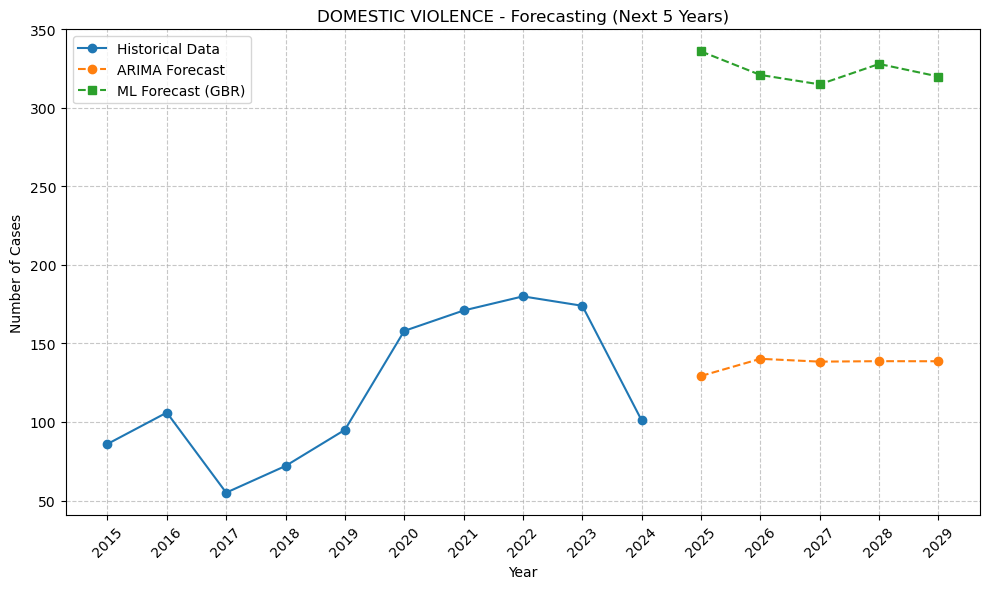

In [17]:
# ---------- Plot ----------
plt.figure(figsize=(10,6))

# Historical
plt.plot(yearly_counts.index.astype(int), yearly_counts.values, marker='o', label="Historical Data")

# ARIMA forecast
plt.plot(arima_forecast.index.astype(int), arima_forecast.values, marker='o', linestyle="--", label="ARIMA Forecast")

# ML forecast
plt.plot(ml_forecast_series.index.astype(int), ml_forecast_series.values, marker='s', linestyle="--", label="ML Forecast (GBR)")

plt.title(f"{crime} - Forecasting (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Cases")

# Combine historical and forecast years for xticks
all_plot_years = sorted(list(set(list(yearly_counts.index.astype(int)) + list(forecast_years))))
plt.xticks(all_plot_years, rotation=45)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Save & show
plt.savefig(OUTPUT_PREFIX + f"_{crime.replace(' ','_')}_forecast.png", dpi=150)
plt.show()



--- Forecasting: Domestic Violence vs Sexual Assault ---

Crime Type: DOMESTIC VIOLENCE
Training years: [2018, 2019, 2020, 2021, 2022, 2023, 2024]
Training counts:
 Year
2018     72
2019     95
2020    158
2021    171
2022    180
2023    174
2024    101
dtype: int64


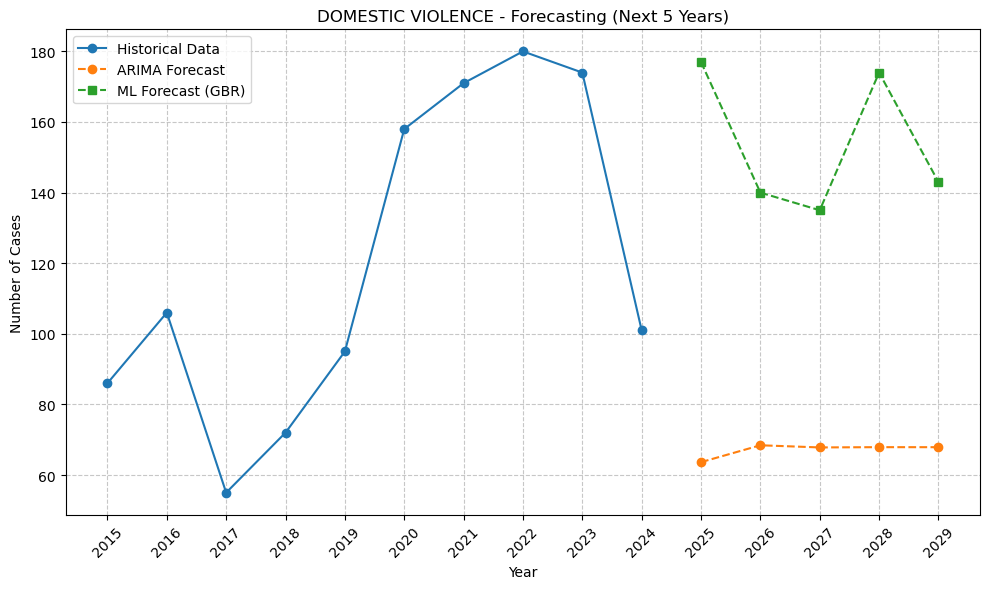


Crime Type: SEXUAL ASSAULT
Training years: [2018, 2019, 2020, 2021, 2022, 2023, 2024]
Training counts:
 Year
2018     72
2019     87
2020    164
2021    181
2022    158
2023    148
2024     95
dtype: int64


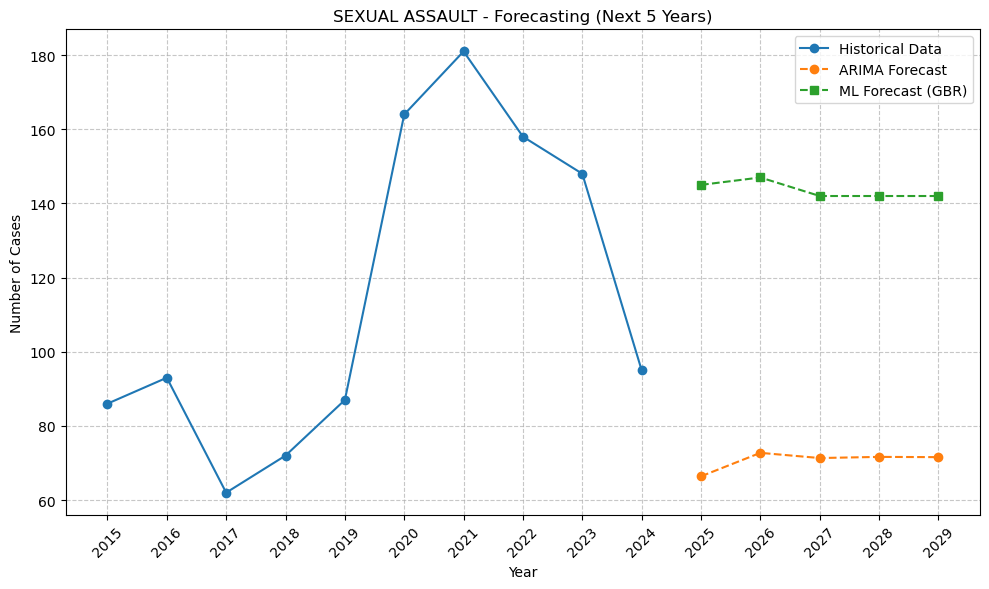

Forecast plots saved for both DV and SA.


In [19]:
# ---------- Forecasting by Crime Type (DV vs SA) ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor

print("\n--- Forecasting: Domestic Violence vs Sexual Assault ---")

crime_types = ['DOMESTIC VIOLENCE', 'SEXUAL ASSAULT']
forecast_results = {}

for crime in crime_types:
    print(f"\nCrime Type: {crime}")
    sub_df = df[df['Crime Description'] == crime].copy()
    
   # Drop rows with missing Year
    sub_df = sub_df.dropna(subset=['Year']).copy()

    # Convert Year to integer
    sub_df['Year'] = sub_df['Year'].astype(int)

    
    # Aggregate yearly counts
    yearly_counts = sub_df.groupby('Year').size().sort_index()
    
    # Ensure continuous index (fill missing years with 0)
    all_years = list(range(int(yearly_counts.index.min()), int(yearly_counts.index.max()) + 1))
    yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
    
    # Train on last 7 years
    train_years = yearly_counts.index[-7:]
    train_counts = yearly_counts.loc[train_years]
    print("Training years:", train_years.tolist())
    print("Training counts:\n", train_counts)
    
    # ---------- ARIMA Forecast ----------
    try:
        arima_model = ARIMA(train_counts, order=(1,1,1))
        arima_res = arima_model.fit()
        arima_forecast = arima_res.forecast(steps=5)
    except Exception as e:
        print("ARIMA failed:", e)
        arima_forecast = pd.Series([np.nan]*5)
    
    forecast_years = [train_years[-1] + i for i in range(1, 6)]
    arima_forecast.index = forecast_years
    
    # ---------- ML Forecast (Gradient Boosting with lags) ----------
    counts_all = yearly_counts.reset_index()
    counts_all.columns = ['Year','count']
    
    for lag in range(1,4):
        counts_all[f'lag_{lag}'] = counts_all['count'].shift(lag)
    counts_all = counts_all.dropna().reset_index(drop=True)
    
    # Use last 7 available rows for training
    train_df = counts_all.tail(7).copy()
    Xf = train_df[['lag_1','lag_2','lag_3']]
    yf = train_df['count']
    
    gbr = GradientBoostingRegressor(random_state=42)
    gbr.fit(Xf, yf)
    
    # Forecast next 5 years using iterative prediction
    last_known = counts_all['count'].values[-3:].tolist()
    ml_forecast = []
    for i in range(5):
        x_input = np.array(last_known[-3:]).reshape(1,-1)
        pred = gbr.predict(x_input)[0]
        ml_forecast.append(max(0, int(round(pred))))
        last_known.append(pred)
    ml_forecast_series = pd.Series(ml_forecast, index=forecast_years)
    
    # Save results
    forecast_results[crime] = {
        "historical": yearly_counts,
        "arima": arima_forecast,
        "ml": ml_forecast_series
    }
    
    # ---------- Plot ----------
    plt.figure(figsize=(10,6))
    
    # Historical
    plt.plot(yearly_counts.index.astype(int), yearly_counts.values, marker='o', label="Historical Data")
    
    # ARIMA forecast
    plt.plot(arima_forecast.index.astype(int), arima_forecast.values, marker='o', linestyle="--", label="ARIMA Forecast")
    
    # ML forecast
    plt.plot(ml_forecast_series.index.astype(int), ml_forecast_series.values, marker='s', linestyle="--", label="ML Forecast (GBR)")
    
    plt.title(f"{crime} - Forecasting (Next 5 Years)")
    plt.xlabel("Year")
    plt.ylabel("Number of Cases")
    
    # Combine historical and forecast years for xticks
    all_plot_years = sorted(list(set(list(yearly_counts.index.astype(int)) + forecast_years)))
    plt.xticks(all_plot_years, rotation=45)
    
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    
    # Save & show plot
    plt.savefig(OUTPUT_PREFIX + f"_{crime.replace(' ','_')}_forecast.png", dpi=150)
    plt.show()

print("Forecast plots saved for both DV and SA.")
